In [1]:
%%capture
from source.active_learning.active_learning_ecg import *

In [ ]:

def eval_prioritization_strategy(data, model, prioritizer, verbose=True):
    """
    :param model:
    :param prioritizer: lambda: indices, predictions: sorted indices
    :return:
    """
    query_steps = 15
    query_size = 64

    train_gen, x_test, y_test = data

    # Get the initial training data
    train_indices = list(range(len(train_gen) * train_gen.batch_size))

    # Select the first query_size samples as the initial training set
    annotated_indices = train_indices[:query_size]
    train_gen_selected = train_gen.remake_on(train_gen.ml_ecgbatchs.sub_es(annotated_indices))

    test_accuracies = []
    for i in range(query_steps):

        # Train the model on the selected data
        model.fit(train_gen_selected, epochs=5, verbose=0)

        # Evaluate the model on the test set
        eval = model.evaluate(x_test, y_test, verbose=0)
        test_accuracies.append(eval[1])

        if verbose:
            print('Training data size of %d => accuracy %f' % (
                train_gen_selected.batch_size * train_gen_selected.n_batch, eval[1]))

        # Prepare for the next step of the loop

        # Create an UnlabeledDataLoader with the remaining indices
        unlabeled_data_loader = UnlabeledDataLoader(train_gen, train_indices, annotated_indices)

        # Make predictions on the unlabeled data
        predictions = model.predict(unlabeled_data_loader)

        # Apply the prioritizer to select the next batch of samples to annotate
        selected_indices = prioritizer(unlabeled_data_loader.unlabeled_indices, predictions)[:query_size]

        # Update the annotated_indices with the new selected_indices
        annotated_indices.extend(selected_indices)

        # Update the train_gen_selected with the updated annotated_indices
        train_gen_selected = train_gen.remake_on(train_gen.ml_ecgbatchs.sub_es(annotated_indices))

    print("- finished -")
    return test_accuracies

In [2]:
# prepare data
es = ECGStream.from_(CSN2022)
es = es.shuffle()
num_max = (len(es))
es1000 = es.sub_es(range(min(1000, num_max)))
es = es.shuffle()
es100 = es.sub_es(range(min(100, num_max)))

label_encoder = LabelEncoder(CSN2022_LABELS)
func_ecg2x = lambda ecg: ecg.data.T[:, 0].reshape((-1, 1))
func_ecg2y = lambda ecg: label_encoder.label2y_single(ecg.label, onehot=True) if ecg.label else np.zeros(len(CSN2022_LABELS))
digitizer = ESDigitizer(16, func_ecg2x, func_ecg2y)
train_gen = digitizer.digitize_es(es1000)
test_gen = digitizer.digitize_es(es100)
x_test, y_test = test_gen.to_xy()
data = train_gen, x_test, y_test

m = es1000[0].data.shape[1]
n = len(CSN2022_LABELS)

  0%|          | 0/6 [00:00<?, ?it/s]

warning, large RAM consumption!


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


In [3]:
# get results of different AL method
acc_baseline = eval_prioritization_strategy(data, KerasRobustCNN3(m, 1, n), trivial_strategy)
acc_entropy = eval_prioritization_strategy(data, KerasRobustCNN3(m, 1, n), max_entropy_strategy)
acc_bt = eval_prioritization_strategy(data, KerasRobustCNN3(m, 1, n), least_margin_strategy)
acc_vr = eval_prioritization_strategy(data, KerasRobustCNN3(m, 1, n), least_confidence_strategy)

Training data size of 32 => accuracy 0.000000
Training data size of 64 => accuracy 0.000000
Training data size of 96 => accuracy 0.000000
Training data size of 128 => accuracy 0.010417
Training data size of 160 => accuracy 0.197917
Training data size of 192 => accuracy 0.364583
Training data size of 224 => accuracy 0.437500
Training data size of 240 => accuracy 0.427083
Training data size of 272 => accuracy 0.447917
Training data size of 304 => accuracy 0.427083
Training data size of 336 => accuracy 0.458333
Training data size of 368 => accuracy 0.500000
Training data size of 400 => accuracy 0.437500
Training data size of 432 => accuracy 0.458333
Training data size of 464 => accuracy 0.468750
Training data size of 480 => accuracy 0.593750
Training data size of 512 => accuracy 0.562500
Training data size of 544 => accuracy 0.583333
Training data size of 576 => accuracy 0.645833
Training data size of 608 => accuracy 0.750000
Training data size of 640 => accuracy 0.718750
Training data si

/home/congyu/congyu_program/pythons/inits/k_active_learning/source/active_learning/active_learning_mnist.py:63: RuntimeWarning: divide by zero encountered in log
  p = predictions * np.log(predictions)
/home/congyu/congyu_program/pythons/inits/k_active_learning/source/active_learning/active_learning_mnist.py:63: RuntimeWarning: invalid value encountered in multiply
  p = predictions * np.log(predictions)


Training data size of 544 => accuracy 0.427083
Training data size of 576 => accuracy 0.583333
Training data size of 608 => accuracy 0.520833
Training data size of 640 => accuracy 0.604167
Training data size of 672 => accuracy 0.447917
Training data size of 704 => accuracy 0.666667
Training data size of 720 => accuracy 0.656250
Training data size of 752 => accuracy 0.145833
Training data size of 784 => accuracy 0.666667
Training data size of 816 => accuracy 0.635417
Training data size of 848 => accuracy 0.729167
Training data size of 880 => accuracy 0.572917
Training data size of 912 => accuracy 0.697917
Training data size of 944 => accuracy 0.614583
Training data size of 960 => accuracy 0.729167
- finished -
Training data size of 32 => accuracy 0.000000
Training data size of 64 => accuracy 0.020833
Training data size of 96 => accuracy 0.135417
Training data size of 128 => accuracy 0.156250
Training data size of 160 => accuracy 0.250000
Training data size of 192 => accuracy 0.437500
Tra

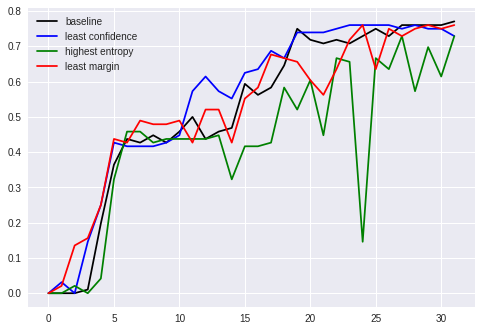

In [4]:
# visualize the performance difference
plt.plot(acc_baseline, 'k', label='baseline')
plt.plot(acc_vr, 'b', label='least confidence')
plt.plot(acc_entropy, 'g', label='highest entropy')
plt.plot(acc_bt, 'r', label='least margin')
plt.legend()